## Obenhaus et al. - Figure S8 - Grid modules

Plots related to Fig. S8

Example display of grid modules and extraction of module characteristics

In [4]:
# Set up basics
import sys, os
from pathlib import Path
import numpy as np 
import pandas as pd
import datajoint as dj
from IPython.display import display

In [5]:
sys.path.append('..')
from dj_schemas.utils import *

In [6]:
# Make plots pretty 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white')
%config InlineBackend.figure_format = 'retina'

In [7]:
# To prevent bug in figure export as pdf: 
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from mpl_toolkits.axes_grid1 import make_axes_locatable
def now():
    # New time every minute
    return datetime.datetime.strftime(datetime.datetime.now(),'%d_%m_%Y %H_%M')

In [8]:
# Standard figure export directory:
figure_dir = '../YOUR_EXPORT_DIRECTORY/'

### Filter sessions / cells

In [9]:
from helpers_topography.plotting_helpers import *
from helpers_topography.utils import *
import cmasher as cmr

In [10]:
import datetime
from datetime import timedelta
from dj_plotter.helpers.plotting_helpers import make_linear_colormap

In [11]:
# Open field sessions 
animal_names = ['88592', '87244', '60480', '82913'] #,'87187','87245','82913'] #['60480','82913','87244','88592','87187']
filtered_sessions = get_filtered_sessions(animal_names,filter_occupancy=True, verbose=False)
filtered_cells    = get_filtered_cells(filtered_sessions) 

Using RoisCorr and compression_ratio cutoff
5026 cells found for {'60480', '82913', '87244', '88592'} over 42 sessions


In [12]:
grids_99 = filtered_cells & (GridScore.proj('gridscore') * CutoffsGridscore & 'gridscore>gridscore_99' & 'gridscore>.5')
grids_95 = filtered_cells & (GridScore.proj('gridscore') * CutoffsGridscore & 'gridscore>gridscore_95')

In [13]:
grid_properties = Ratemap.aggr(Ratemap.Fields, avg_fieldsize="avg(field_area)") * \
                           Ratemap.proj('no_fields') * \
                           GridScore.proj('gridscore') * \
                           GridScore.Stats.proj('gs_spacing','gs_orientation','gs_ellipse_theta','gs_ellipse_aspect_ratio','gs_orientations_std')

In [14]:
grid_stats = pd.DataFrame((Session.proj('animal_name', 'timestamp') * \
                           grid_properties * \
                           MapParams.proj('bin_size') \
                           & grids_99 \
                           & cell_parameter_dict
                           ).fetch())

columns = ['animal_name', 'session_name', 'cell_id', 'timestamp', 
           'gs_orientation', 'no_fields', 'gs_spacing', 'gs_ellipse_theta', 
           'gs_ellipse_aspect_ratio', 'avg_fieldsize']

grid_stats['gs_orientation']   = np.degrees(grid_stats['gs_orientation'])
grid_stats['gs_ellipse_theta'] = np.degrees(grid_stats['gs_ellipse_theta'])
grid_stats['gs_spacing']       = grid_stats['gs_spacing'] * grid_stats['bin_size']

# Constrain to core info 
grid_stats = grid_stats[columns]

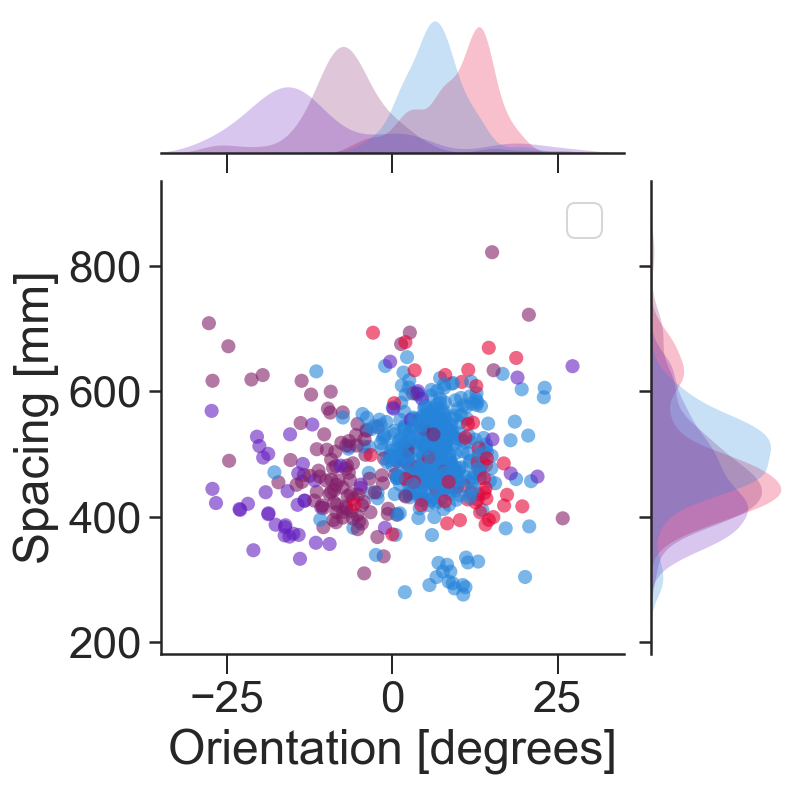

In [15]:
sns.set(style='white', font_scale=2.)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

g = sns.jointplot(
    data=grid_stats,
    x="gs_orientation", y="gs_spacing", hue="animal_name", palette='cmr.guppy_r',
    kind="scatter", ratio=3, joint_kws={'linewidth': 0, 's': 50, 'marker':'o', 'alpha': .6}, 
    marginal_kws={'lw': 0, 'common_norm': False, 'gridsize':400,'bw_method': .30}
)

# Put the legend out of the figure
g.ax_joint.legend('')
g.ax_joint.set_xlabel('Orientation [degrees]')
g.ax_joint.set_ylabel('Spacing [mm]')

g.ax_joint.set_xlim(-35,35)
#g.ax_joint.set_ylim(210,740)

g.savefig(figure_dir + f'gridmodules {now()}.pdf', bbox_inches='tight')

In [16]:
len(grid_stats)

609

In [17]:
figure_dir

'../YOUR_EXPORT_DIRECTORY/'

In [18]:
from helpers_topography.grid_modules import extract_grid_modules, embed_existing_module, plot_maps

### Extract modules

In [19]:
# Focus on one animal
animal = '88592'

In [20]:
animal_grid_stats = grid_stats.loc[grid_stats.animal_name == animal].copy()

Running stats over ... 
gs_orientation
gs_spacing


Using MaxAbsScaler
Using PCA
Explained variance by 2 components: 1.00
Data has now the following dimensions: (402, 2)
Using HDBSCAN clustering
Found 4 modules ([-1  0  1  2  3])


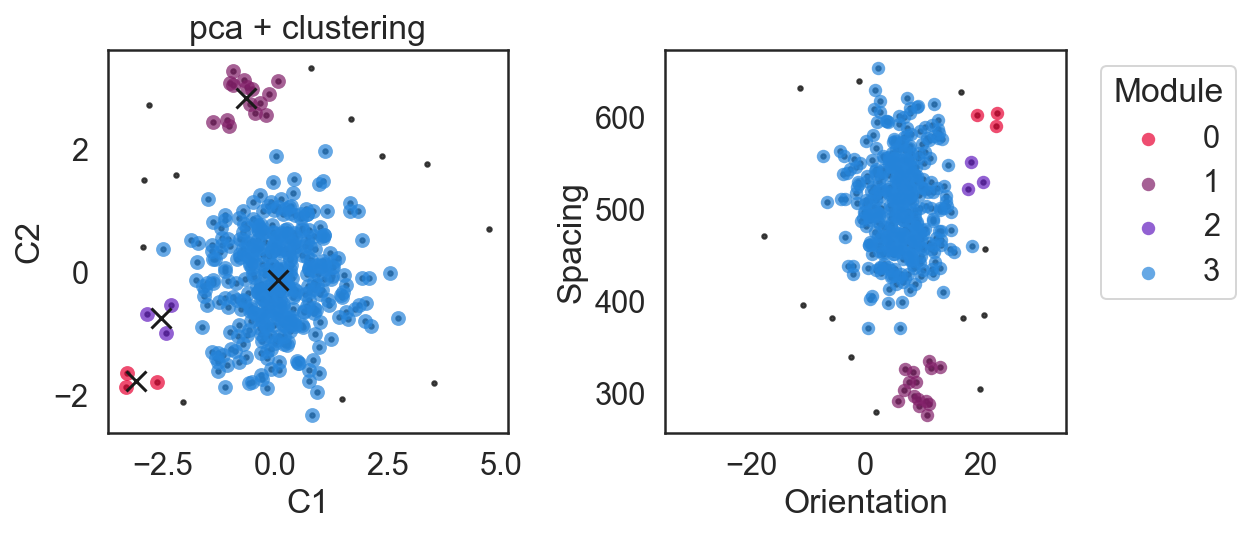

In [21]:
columns_clustering = ['gs_orientation', 'gs_spacing']
results_clustering = extract_grid_modules(animal_grid_stats, 
                                          columns_clustering, 
                                          clustering='hdbscan',
                                          plot=True, 
                                          save_path=figure_dir)

# Make results retrievable
reduced_gridstats = results_clustering[5]
labels            = results_clustering[4]
cluster_centers   = results_clustering[3]

scaler     = results_clustering[0]
reducer    = results_clustering[1]
clusterer  = results_clustering[2]

classifier = results_clustering[6]

### Now add new cells to the skeleton

In [22]:
grid_stats_95 = pd.DataFrame((Session.proj('animal_name', 'timestamp') * \
                           grid_properties * \
                           MapParams.proj('bin_size') \
                           & grids_95 \
                           & cell_parameter_dict
                           ).fetch())

grid_stats_95['gs_orientation']   = np.degrees(grid_stats_95['gs_orientation'])
grid_stats_95['gs_ellipse_theta'] = np.degrees(grid_stats_95['gs_ellipse_theta'])
grid_stats_95['gs_spacing']       = grid_stats_95['gs_spacing'] * grid_stats_95['bin_size']

In [23]:
bin_size = list(set(grid_stats_95['bin_size']))[0]

In [24]:
# Animal 
animal_grid_stats_95  = grid_stats_95.loc[grid_stats_95.animal_name == animal].copy()

In [25]:
reduced_gridstats_95, labels_95 = embed_existing_module(animal_grid_stats_95[columns_clustering], scaler, reducer, classifier)

In [26]:
colors = make_linear_colormap(np.arange(len(cluster_centers)), cmap='cmr.guppy')

In [27]:
save_path = figure_dir
save_path = Path(save_path)

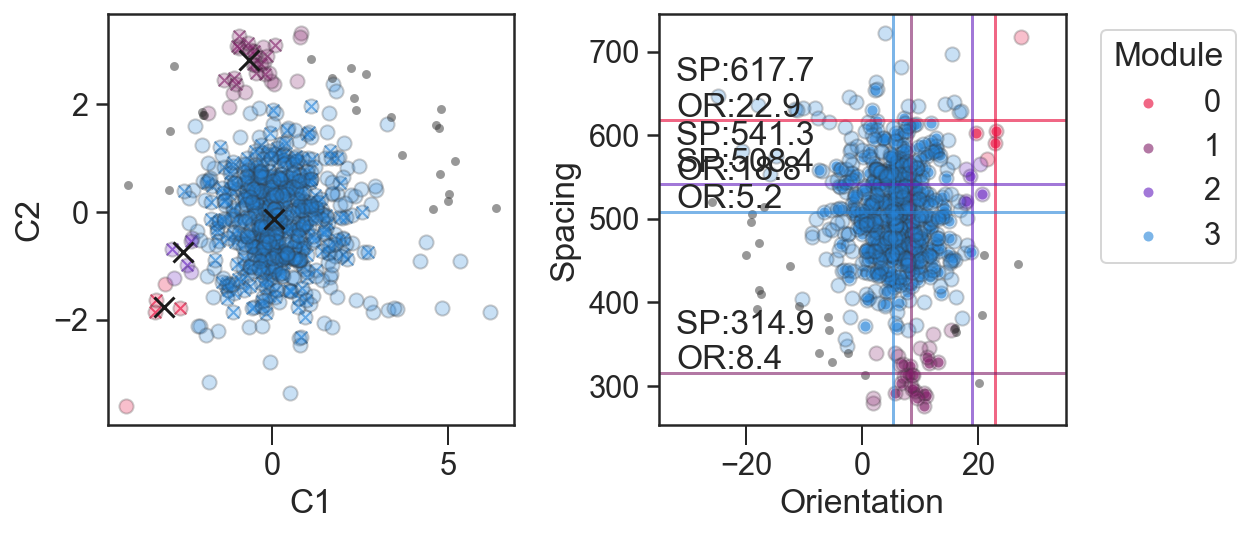

In [28]:
sns.set(style='white', font_scale=1.4)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

figure=plt.figure(figsize=(9,4))

ax1=figure.add_subplot(121)
for no,center in enumerate(cluster_centers):
    ax1.scatter(reduced_gridstats[:,0][labels==no], reduced_gridstats[:,1][labels==no], 
                s=35, marker='x', lw=1, color=colors[no], alpha=.6)    
ax1.set_xlabel('C1')
ax1.set_ylabel('C2')

ax2=figure.add_subplot(122)
saved_figs_ = []
for no,center in enumerate(cluster_centers):
    p = ax2.scatter(animal_grid_stats.gs_orientation.iloc[labels==no], animal_grid_stats.gs_spacing.iloc[labels==no], 
                    color=colors[no], s=25, lw=0, alpha=.6, label=no)
    saved_figs_.append(p)
ax2.legend(handles=saved_figs_, title='Module', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xlabel('Orientation')
ax2.set_ylabel('Spacing')

# 
for no, (reduced_95, label_95) in enumerate(zip(reduced_gridstats_95, labels_95)):
    if label_95 > -1:
        ax1.scatter(reduced_95[0],reduced_95[1], s=50, lw=1, alpha=.25, edgecolors='#333', color=colors[label_95])
        ax2.scatter(animal_grid_stats_95.gs_orientation.iloc[no], animal_grid_stats_95.gs_spacing.iloc[no], 
                    color=colors[label_95], s=50, lw=1, alpha=.25, edgecolors='#333')
        
    else:
        ax1.scatter(reduced_95[0],reduced_95[1], s=20, lw=0, alpha=.5, color='#333')
        ax2.scatter(animal_grid_stats_95.gs_orientation.iloc[no], animal_grid_stats_95.gs_spacing.iloc[no], 
                    s=20, lw=0, alpha=.5, color='#333')
        

# Draw cluster centers just for reference
for no,center in enumerate(cluster_centers):
    ax1.scatter(center[0],center[1], s=100, marker='x', color='k')
    
# Extract new centers over all (newly added) points
for no, _ in enumerate(cluster_centers):
    mean_x = animal_grid_stats_95.gs_orientation.loc[labels_95==no].mean()
    mean_y = animal_grid_stats_95.gs_spacing.loc[labels_95==no].mean()
    ax2.axvline(x=mean_x, alpha=.6, color=colors[no])
    ax2.axhline(y=mean_y, alpha=.6, color=colors[no])
    ax2.text(-32, mean_y+5, f'SP:{mean_y:.1f} \nOR:{mean_x:.1f}')
    
ax2.set_xlim(-35,35)
    
plt.tight_layout()
figure.savefig(figure_dir + 'pca and clustering.pdf', bbox_inches='tight')